---
title: "Beer Markets Blog"
author: Owen Ellick
date: March 30, 2025
format:
  html
---

# **Decoding Beer Prices: A Linear Regression Journey into Market Dynamics**

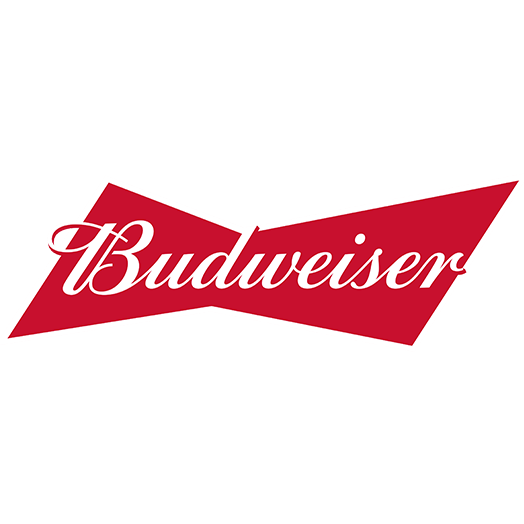

# Introduction

Ever wondered what truly dictates the price of your favorite beer? Is it the brand, the size, or perhaps the market you're in? In this post, we'll embark on a journey into the world of beer markets, using linear regression to unravel the complex factors that influence beer prices. We'll explore how different models capture the nuances of this market, from simple additive effects to intricate interactions between brands, sizes, and promotions.



# Loading the Data

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, when, log
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import pow

spark = SparkSession.builder.master("local[*]").getOrCreate()



In [ ]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler,
    and inserts a dashed horizontal line after the Intercept row. The table includes separate columns
    for the 95% confidence interval lower and upper bounds for each coefficient (computed at the 5% significance level)
    and an "Observations" row (using model.summary.numInstances) above the R² row.
    The RMSE row is placed as the last row.

    The columns are ordered as:
        Metric | Value | Significance | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    For the "Value", "Std. Error", "95% CI Lower", and "95% CI Upper" columns, commas are inserted every three digits,
    with 3 decimal places (except for Observations which is formatted as an integer with commas).

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Extract coefficients and standard errors as NumPy arrays
    coeffs = model.coefficients.toArray()

    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element)
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Compute t-statistics for feature coefficients (t = beta / SE(beta))
    # t_stats = coeffs / std_errors
    t_stats = model.summary.tValues

    # Degrees of freedom: number of instances minus number of predictors minus 1 (for intercept)
    df = model.summary.numInstances - len(coeffs) - 1

    # Compute the t-critical value for a 95% confidence interval (two-tailed, 5% significance)
    t_critical = stats.t.ppf(0.975, df)

    # Compute two-tailed p-values for each feature coefficient
    # p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]
    p_values = model.summary.pValues

    # Function to assign significance stars based on p-value
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build the table rows.
    # Order: Metric, Value, Significance, Std. Error, p-value, 95% CI Lower, 95% CI Upper.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se
        table.append([
            "Beta: " + feature,       # Metric name
            beta,                     # Beta estimate (Value)
            significance_stars(p),    # Significance stars
            se,                       # Standard error
            p,                        # p-value
            ci_lower,                 # 95% CI lower bound
            ci_upper                  # 95% CI upper bound
        ])

    # Compute and add the intercept row with its SE, p-value, significance, and CI (if available)
    if intercept_se is not None:
        intercept_t = model.intercept / intercept_se
        intercept_p = 2 * (1 - stats.t.cdf(np.abs(intercept_t), df))
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_se = ""
        intercept_p = ""
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""

    table.append([
        "Intercept",
        model.intercept,
        intercept_sig,
        intercept_se,
        intercept_p,
        ci_intercept_lower,
        ci_intercept_upper
    ])

    # Append overall model metrics:
    # Insert an Observations row using model.summary.numInstances,
    # then an R² row, and finally the RMSE row as the last row.
    table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
    table.append(["R²", model.summary.r2, "", "", "", "", ""])
    table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table.
    # For the "Value" (index 1), "Std. Error" (index 3), "95% CI Lower" (index 5), and "95% CI Upper" (index 6) columns,
    # format with commas and 3 decimal places, except for Observations which should be an integer with commas.
    # For the p-value (index 4), format to 3 decimal places.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                # Format Observations as integer with commas, no decimals.
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if i in [1, 3, 5, 6]:
                    formatted_row.append(f"{item:,.3f}")
                elif i == 4:
                    formatted_row.append(f"{item:.3f}")
                else:
                    formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Generate the table string using tabulate.
    table_str = tabulate(
        formatted_table,
        headers=["Metric", "Value", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"],
        tablefmt="pretty",
        colalign=("left", "right", "center", "right", "right", "right", "right")
    )

    # Insert a dashed line after the Intercept row for clarity.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(MODEL, ASSEMBLER))

def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category

In [ ]:
beer_markets = pd.read_csv(
  'https://bcdanl.github.io/data/beer_markets_all_cleaned.csv'
)
print(beer_markets)

In [ ]:

filtered_df = beer_markets[
    beer_markets['container'].isin(['CAN', 'NON REFILLABLE BOTTLE'])]
print(filtered_df)

In [ ]:
df = spark.createDataFrame(filtered_df)

dtrain, dtest= df.randomSplit([0.67, 0.33], seed=42)

# Model Setups

In [ ]:
dtrain = dtrain.withColumn('log_price_floz', log(col('price_floz'))).withColumn('log_beer_floz', log(col('beer_floz')))
dtest = dtest.withColumn('log_price_floz', log(col('price_floz'))).withColumn('log_beer_floz', log(col('beer_floz')))

In [ ]:
markets = [row.market for row in dtrain.select('market').distinct().collect()]
markets.remove('BUFFALO-ROCHESTER')
for market in markets:
    dtrain = dtrain.withColumn(f'market_{market}', when(col('market') == market, 1).otherwise(0))
    dtest = dtest.withColumn(f'market_{market}', when(col('market') == market, 1).otherwise(0))

In [ ]:
brands = [row.brand for row in dtrain.select('brand').distinct().collect()]
brands.remove('BUD_LIGHT')
for brand in brands:
    dtrain = dtrain.withColumn(f'brand_{brand}', when(col('brand') == brand, 1).otherwise(0))
    dtest = dtest.withColumn(f'brand_{brand}', when(col('brand') == brand, 1).otherwise(0))


In [ ]:
dtrain = dtrain.withColumn('container_CAN', when(col('container') == 'CAN', 1).otherwise(0))
dtest = dtest.withColumn('container_CAN', when(col('container') == 'CAN', 1).otherwise(0))

dtrain = dtrain.withColumn('promo', col('promo').cast('integer'))
dtest = dtest.withColumn('promo', col('promo').cast('integer'))

# Model 1: The Basic Additive Model

In [ ]:
market_cols = [col_name for col_name in dtrain.columns if col_name.startswith('market_') and col_name != 'market_BUFFALO-ROCHESTER']
brand_cols = [col_name for col_name in dtrain.columns if col_name.startswith('brand_') and col_name != 'brand_BUD_LIGHT']

assembler1 = VectorAssembler(inputCols=market_cols + brand_cols + ['container_CAN', 'log_beer_floz'], outputCol='features')
dtrain1 = assembler1.transform(dtrain)
dtest1 = assembler1.transform(dtest)

model1 = LinearRegression(featuresCol='features', labelCol='log_price_floz').fit(dtrain1)
predictions1 = model1.transform(dtest1)

print("Model 1 Summary:")
print(f"  Coefficients: {model1.coefficients}")
print(f"  Intercept: {model1.intercept}")
print(f"  R-squared: {model1.summary.r2}")
print(f"  RMSE: {model1.summary.rootMeanSquaredError}")

- Interpretation: This model estimates the baseline log(price_per_floz) for a specific reference market and brand. Each coefficient represents the average change in log(price_per_floz) for a one-unit change in the corresponding variable.
- Limitations: It doesn't account for interactions between variables, like how beer size might affect different brands differently.

# Model 2: Interaction with Brand and Size

In [ ]:
interaction_cols_beer_floz = [f'{brand}_log_beer_floz' for brand in brand_cols] # Change here to use the complete name
for brand in brand_cols:
    dtrain = dtrain.withColumn(f'{brand}_log_beer_floz', col(brand) * col('log_beer_floz')) # Use col(brand) instead
    dtest = dtest.withColumn(f'{brand}_log_beer_floz', col(brand) * col('log_beer_floz')) # Use col(brand) instead

assembler2 = VectorAssembler(inputCols=market_cols + brand_cols + ['container_CAN', 'log_beer_floz'] + interaction_cols_beer_floz, outputCol='features')
dtrain2 = assembler2.transform(dtrain)
dtest2 = assembler2.transform(dtest)

model2 = LinearRegression(featuresCol='features', labelCol='log_price_floz').fit(dtrain2)
predictions2 = model2.transform(dtest2)

print("\nModel 2 Summary:")
print(f"  Coefficients: {model2.coefficients}")
print(f"  Intercept: {model2.intercept}")
print(f"  R-squared: {model2.summary.r2}")
print(f"  RMSE: {model2.summary.rootMeanSquaredError}")

- Interpretation: This model allows the effect of beer size on price to vary across brands, capturing potential differences in price elasticity.


# Model 3: The Full Interaction Model

In [ ]:
interaction_cols_promo_beer_floz = [f'{brand}_promo_log_beer_floz' for brand in brand_cols]
interaction_cols_promo = [f'{brand}_promo' for brand in brand_cols]

dtrain = dtrain.withColumn('promo_log_beer_floz', col('promo') * col('log_beer_floz'))
dtest = dtest.withColumn('promo_log_beer_floz', col('promo') * col('log_beer_floz'))

for brand in brand_cols:
    dtrain = dtrain.withColumn(f'{brand}_promo', col(brand) * col('promo')) # Use the complete brand column name
    dtest = dtest.withColumn(f'{brand}_promo', col(brand) * col('promo')) # Use the complete brand column name
    dtrain = dtrain.withColumn(f'{brand}_promo_log_beer_floz', col(brand) * col('promo') * col('log_beer_floz')) # Use the complete brand column name
    dtest = dtest.withColumn(f'{brand}_promo_log_beer_floz', col(brand) * col('promo') * col('log_beer_floz')) # Use the complete brand column name

assembler3 = VectorAssembler(inputCols=market_cols + brand_cols + ['container_CAN', 'log_beer_floz', 'promo_log_beer_floz'] + interaction_cols_beer_floz + interaction_cols_promo + interaction_cols_promo_beer_floz, outputCol='features')
dtrain3 = assembler3.transform(dtrain)
dtest3 = assembler3.transform(dtest)

model3 = LinearRegression(featuresCol='features', labelCol='log_price_floz').fit(dtrain3)
predictions3 = model3.transform(dtest3)

print("\nModel 3 Summary:")
print(f"  Coefficients: {model3.coefficients}")
print(f"  Intercept: {model3.intercept}")
print(f"  R-squared: {model3.summary.r2}")
print(f"  RMSE: {model3.summary.rootMeanSquaredError}")

- Interpretation: This model captures the most complex relationships, including how promotions affect price across different brands and sizes.
- Challenges: The increased complexity can make interpretation more difficult and increase the risk of overfitting.

# Conclusion

- This analysis demonstrates the power of linear regression in decoding the intricate factors that drive beer prices. By building and comparing different models, we gain a deeper understanding of the beer market, revealing the nuanced interplay between brands, sizes, markets, and promotions.